# Supervised Machine Learning - Test Your Knowledge Key

In [1]:
library(readxl);
library(lubridate);
library(tidyverse);
library(gtsummary);
library(flextable);
library(caret);
library(randomForest);


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.3     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.3     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
#Uighur


Attaching package: ‘flextable’


The following objects are masked from ‘package:gtsummary’:

    as_flextable, continuous_summary


The following object is masked from ‘package:purrr’:

    compose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.1

Type rfNews() to see new f

In [2]:
# Load the data
manganese_data <- data.frame(read_excel("Module5/Module5_Manganese_Data.xlsx"))

# View the top of the dataset
head(manganese_data) 

,Tax_ID,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Longtitude,Latitude,Stream_Distance,Elevation,Detect_Concentration
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1006004,9/24/12,52,165,41,60.0,7.7,-80.29918,35.17970,811.9613,611.499,D
2,1024009,12/17/15,40,445,42,2.0,7.3,-80.31061,35.15487,341.7654,688.452,D
3,1054019,2/2/15,45,160,40,40.0,7.4,-80.33170,35.16158,634.2669,692.789,D
4,1057017,10/22/12,42,440,57,1.5,8.0,-80.32263,35.13962,855.4713,692.789,ND
5,1060006,1/3/11,48,120,42,25.0,7.1,-80.32911,35.13027,163.5688,683.387,D
6,1066006,12/15/15,60,280,32,10.0,8.2,-80.32205,35.10479,725.7672,614.599,D


Like we did in the module, we'll start by changing some of the data types. 

In [3]:
manganese_data = manganese_data %>%
    # Converting `Detect_Concentration` from a character to a factor
    mutate(Detect_Concentration = relevel(factor(Detect_Concentration), ref = "ND"),
        # Converting water sample date from a character to a date type 
        Water_Sample_Date = mdy(Water_Sample_Date)) %>%
    # Removing tax id and only keeping the predictor and outcome variables in the dataset
    # This allows us to put the entire dataframe as is into RF
    select(-Tax_ID)

head(manganese_data)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Longtitude,Latitude,Stream_Distance,Elevation,Detect_Concentration
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2012-09-24,52,165,41,60.0,7.7,-80.29918,35.17970,811.9613,611.499,D
2,2015-12-17,40,445,42,2.0,7.3,-80.31061,35.15487,341.7654,688.452,D
3,2015-02-02,45,160,40,40.0,7.4,-80.33170,35.16158,634.2669,692.789,D
4,2012-10-22,42,440,57,1.5,8.0,-80.32263,35.13962,855.4713,692.789,ND
5,2011-01-03,48,120,42,25.0,7.1,-80.32911,35.13027,163.5688,683.387,D
6,2015-12-15,60,280,32,10.0,8.2,-80.32205,35.10479,725.7672,614.599,D


Next, setting up cross validation and parameters to be tuned.

In [4]:
set.seed(12)

manganese_index = createFolds(manganese_data$Detect_Concentration, k = 5) 

ntree_values = c(50, 250, 500) # number of decision trees 
p = dim(manganese_data)[2] - 1 # number of predictor variables in the dataset
mtry_values = c(sqrt(p), p/2, p) # number of predictors to be used in the model

Predicting with RF

In [6]:
# Setting the seed again so the predictions are consistent
set.seed(12)

# Creating an empty dataframe to save the variable importance
variable_importance_df = data.frame()

# Iterating through the cross validation folds
for (i in 1:length(manganese_index)){
    # Training data
    data_train = manganese_data[-manganese_index[[i]],]
    
    # Test data
    data_test = manganese_data[manganese_index[[i]],]
    
    # Creating empty lists and dataframes to store errors 
    reg_rf_pred_tune = list()
    rf_OOB_errors = list()
    rf_error_df = data.frame()
    
    # Tuning parameters: using ntree and mtry values to determine which combination yields the smallest OOB error 
    # from the validation datasets
    for (j in 1:length(ntree_values)){
        for (k in 1:length(mtry_values)){
            
            # Running RF to tune parameters
            reg_rf_pred_tune[[k]] = randomForest(Detect_Concentration ~ ., data = data_train, 
                                                 ntree = ntree_values[j], mtry = mtry_values[k])
            # Obtaining the OOB error
            rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                   "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
            
            # Storing the values in a dataframe
            rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
        }
    }
    
    # Finding the lowest OOB error using best number of predictors at split
    best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

    # Now running RF on the entire training set with the tuned parameters
    reg_rf <- randomForest(Detect_Concentration ~ ., data = data_train,
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)],
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

    # Predicting on test set and adding the predicted values as an additional column to the test data
    data_test$Pred_Detect_Concentration = predict(reg_rf, newdata = data_test, type = "response")

    # extracting variable importance
    variable_importance_values = data.frame(importance(reg_rf)) %>%
        rownames_to_column(var = "Predictor")
    variable_importance_df = rbind(variable_importance_df, variable_importance_values)
}

# Taking average
variable_importance_df = variable_importance_df %>%
    group_by(Predictor) %>%
    summarise(MeanDecreaseGini = mean(MeanDecreaseGini)) %>%
    # sorting by most important variables
    arrange(-MeanDecreaseGini)

# Viewing the model's variable importance
variable_importance_df

Predictor,MeanDecreaseGini
<chr>,<dbl>
Longtitude,44.86339
Latitude,35.79763
Stream_Distance,31.94600
Casing_Depth,28.40971
pH,28.04137
Well_Depth,26.63281
Water_Sample_Date,25.38085
Elevation,21.15887
Static_Water_Depth,19.19361


Reformatting the dataframe for plotting

In [9]:
# Adding spaces between the variables that need the space
modified_variable_importance_df = variable_importance_df %>%
     mutate(Predictor = ifelse(Predictor == "Casing_Depth", "Casing Depth",
                ifelse(Predictor == "Water_Sample_Date", "Water Sample Date",
                    ifelse(Predictor == "Flow_Rate", "Flow Rate",
                        ifelse(Predictor == "Well_Depth", "Well Depth",
                            ifelse(Predictor == "Static_Water_Depth", "Static Water Depth", 
                                   ifelse(Predictor == "Stream_Distance", "Stream Distance", 
                                          Predictor)))))))

# Saving the order of the variables from lowest to highest mean decrease gini by putting into a factor
predictor_order = rev(modified_variable_importance_df$Predictor)
modified_variable_importance_df$Predictor = factor(modified_variable_importance_df$Predictor, levels = predictor_order)

head(modified_variable_importance_df)

Predictor,MeanDecreaseGini
<fct>,<dbl>
Longtitude,44.86339
Latitude,35.79763
Stream Distance,31.94600
Casing Depth,28.40971
pH,28.04137
Well Depth,26.63281


## Variable Importance Plot

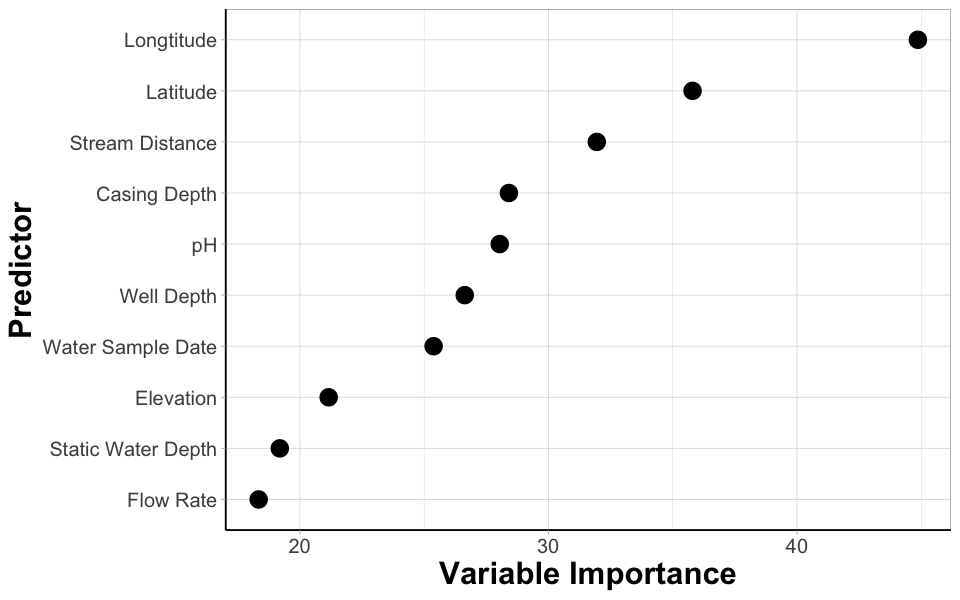

In [10]:
options(repr.plot.width=8, repr.plot.height=5) #changing plot size

ggplot(data = modified_variable_importance_df , 
             aes(x = MeanDecreaseGini, y = Predictor, size = 3)) + 
  geom_point() + 

  theme_light() + 
  theme(axis.line = element_line(color = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Variable Importance', y = 'Predictor') + #changing axis labels 
  
  guides(size = "none")#removing size legend

From the variable importance dataframe and plot, we can see that a sample's location (indicated by longtitude and latitutde) had the greatest impact on RF followed by stream distance, casing depth, pH, well depth, water sample date, elevation, static water depth, and flow rate. 

Since longtitude and latitude have been identified as the predictors with the highest variable importance, they will be used as the two predictors for the decision boundary plot.

### Decision Boundary Calculation

In [29]:
# Creating a dataframe with variables based on the highest predictors
highest_predictivity_data = data.frame(manganese_data[,c("Longtitude", "Casing_Depth", "Detect_Concentration")])

# Training RF
rf_detect_manganese = randomForest(Detect_Concentration~., data = highest_predictivity_data)

In [30]:
get_grid_df <- function(classification_model, data, resolution = 100) {
    # This function predicts the outcome (Detect_Concentration) at evenly spaced data points using the two variables (pH and casing depth)
    # to create a decision boundary between the outcome classes (detect and non-detect samples).

    # :parameters: a classification-based supervised machine learning model, dataset containing the predictors and outcome variable,
    # specifies the number of data points to make between the minimum and maximum predictor values
    # :output: a grid of values for both predictors and their corresponding predicted outcome class

    # Grabbing only the predictor data
    predictor_data <- data[,1:2]
    
    # Creating a dataframe that contains the min and max for both features
    min_max_df <- sapply(predictor_data, range, na.rm = TRUE)

    # Creating a vector of evenly spaced points between the min and max for the first variable (casing depth)
    variable1_vector <- seq(min_max_df[1,1], min_max_df[2,1], length.out = resolution)
    # Creating a vector of evenly spaced points between the min and max for the second variable (pH)
    variable2_vector <- seq(min_max_df[1,2], min_max_df[2,2], length.out = resolution)

    # Creating a dataframe of grid values by combining the two vectors
    grid_df <- data.frame(cbind(rep(variable1_vector, each = resolution), rep(variable2_vector, time = resolution)))
    colnames(grid_df) <- colnames(min_max_df)
    
    # Predicting class label based on all the predictor pairs of data
    grid_df$Pred_Class = predict(classification_model, grid_df, type = "class")
    
    return(grid_df)
}

# calling function
grid_df_rf = get_grid_df(rf_detect_manganese, highest_predictivity_data)
head(grid_df_rf)

,Longtitude,Casing_Depth,Pred_Class
,<dbl>,<dbl>,<fct>
1,-80.83541,27.00000,ND
2,-80.83541,28.39394,ND
3,-80.83541,29.78788,ND
4,-80.83541,31.18182,ND
5,-80.83541,32.57576,ND
6,-80.83541,33.96970,ND


## Decision Boundary Plot

Warning message:
“Removed 700 rows containing non-finite values (`stat_contour()`).”
Warning message:
“Removed 89 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 700 rows containing missing values (`geom_point()`).”


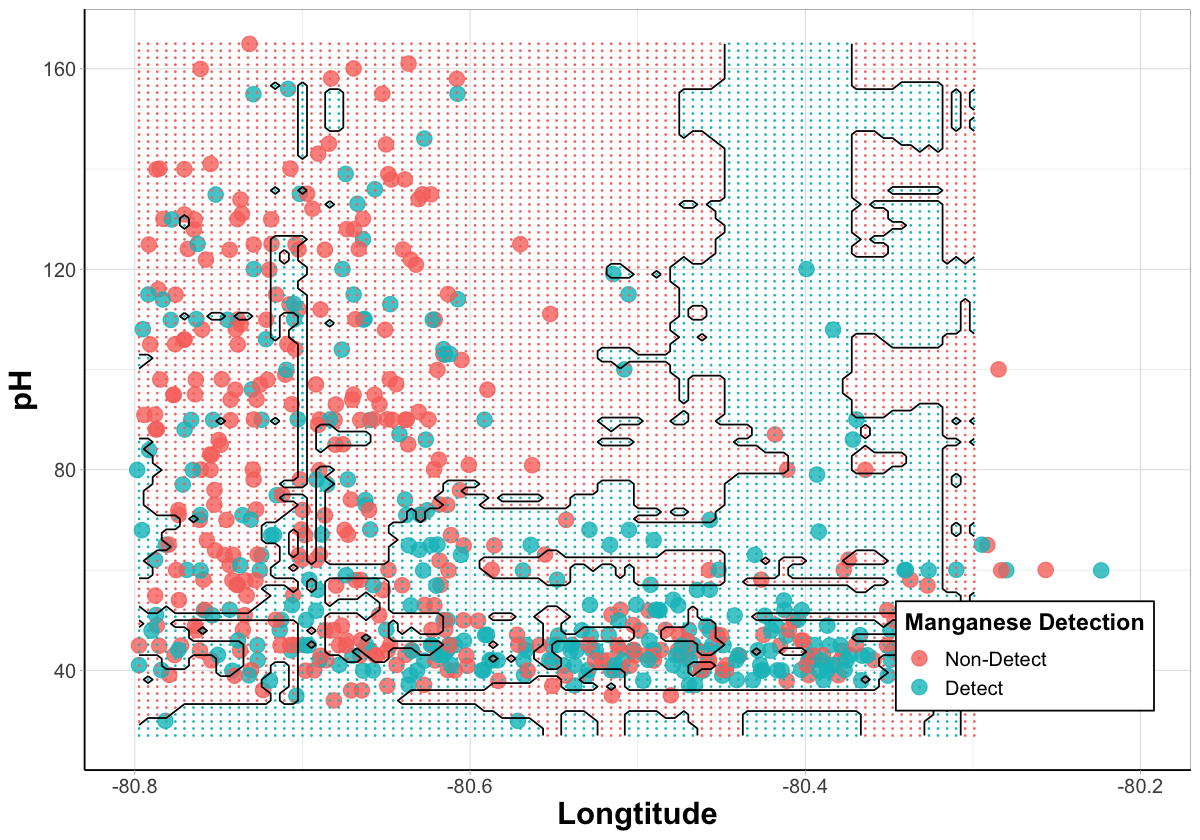

In [39]:
options(repr.plot.width=10, repr.plot.height=7) #changing plot size

ggplot() +
  geom_point(data = manganese_data, aes(x = Longtitude, y = Casing_Depth, color = Detect_Concentration),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_rf, aes(x = Longtitude, y = Casing_Depth, z = as.numeric(Pred_Class == "D")), 
               color = "black", breaks = 0.5) + # adds contour line
  geom_point(data = grid_df_rf, aes(x = Longtitude, y = Casing_Depth, color = Pred_Class), 
             size = 0.1) + # shades plot
  ylim(27, 165) + # changes the limits of the x axis
  xlim(-80.8, -80.2) + # changes the limits of the y axis

  theme_light() + 
  theme(axis.line = element_line(color = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.85,0.15), # move legend to top left corner
        legend.background = element_rect(color = 'black', fill = 'white', linetype = 'solid'), # changes legend background
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Longtitude', y = 'pH') + #changing axis labels 

  scale_color_discrete(name = "Manganese Detection", # renaming the legend
                      labels = c('Non-Detect','Detect')) # renaming the classes